### 1.Processing Data

In [1]:
import sys
sys.path.append('..')

from utilities import *

warnings.filterwarnings('ignore')

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

train_data, test_data = sa.divide_data_for_train_and_test(data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 2. Linear Regression

In [2]:
model, design_info, selected_columns = sa.modelization_with_backward_elimination(train_data)

### 3. Create exogenous variables

In [3]:
X_train_exog = sa.x_train_exog(train_data, selected_columns, model)

✅ YES - All features match perfectly!


In [4]:
X_train_exog_clean, removed_vars, cond_before, cond_after = sa.clean_exogenous_variables(
    X_train_exog, corr_threshold=0.95, verbose=False
)

X_test_exog = sa.x_test_exog(test_data, selected_columns, design_info)

Processing x_exog variables

In [5]:
X_test_exog_clean_temp, removed_test, cond_before_test, cond_after_test = sa.clean_exogenous_variables(
    X_test_exog, corr_threshold=0.95, verbose=False
)

train_columns = set(X_train_exog_clean.columns)
test_columns_available = set(X_test_exog_clean_temp.columns)

missing_in_test = train_columns - test_columns_available
extra_in_test = test_columns_available - train_columns

X_test_exog_clean = pd.DataFrame(index=X_test_exog_clean_temp.index)

for col in X_train_exog_clean.columns:
    if col in X_test_exog_clean_temp.columns:
        X_test_exog_clean[col] = X_test_exog_clean_temp[col]
    else:
        X_test_exog_clean[col] = 0.0

X_test_exog_clean = X_test_exog_clean[X_train_exog_clean.columns]


In [6]:
auto_arima_model_clean = auto_arima( 
    y=train_data['volume.sales'],
    X=X_train_exog_clean,
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    information_criterion='aic'
)

print(auto_arima_model_clean.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=14917.986, Time=0.37 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=14795.345, Time=15.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=26.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=18360.693, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=14919.841, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=33.51 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=144.32 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=14794.161, Time=9.34 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=89.93 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=121.73 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=14795.855, Time=17.10 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=14797.848, Time=35.15 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=14777.748, Time=8.22 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC=inf, Time=31.21 sec
 ARIMA(0,0,0)(0,1,1)[12]      

In [7]:
arima_res = auto_arima_model_clean.arima_res_

forecast = arima_res.get_forecast(steps=len(test_data), exog=X_test_exog_clean)

predictions = forecast.predicted_mean
conf_int = forecast.conf_int()

# ========== CREAR DATAFRAME CON PREDICCIONES Y CONTEXTO ==========
# Esto permite filtrar las predicciones fácilmente por serie específica
# Las predicciones están en el mismo orden que test_data (fila por fila)
predictions_with_context = test_data.copy()

# Agregar las predicciones y intervalos de confianza
predictions_with_context['prediction'] = predictions.values if hasattr(predictions, 'values') else predictions
predictions_with_context['predicted_mean'] = predictions.values if hasattr(predictions, 'values') else predictions
predictions_with_context['prediction_lower'] = conf_int.iloc[:, 0].values
predictions_with_context['prediction_upper'] = conf_int.iloc[:, 1].values

print("✅ DataFrame con predicciones y contexto creado")
print(f"   - Columnas: {list(predictions_with_context.columns)}")
print(f"   - Observaciones: {len(predictions_with_context)}")
print(f"   - Series únicas: {predictions_with_context.groupby(['supermarket', 'variant', 'pack.size']).size().shape[0]}")


✅ DataFrame con predicciones y contexto creado
   - Columnas: ['date', 'volume.sales', 'unit.sales', 'value.sales', 'supermarket', 'variant', 'pack.size', 'brand', 'price', 'prediction', 'predicted_mean', 'prediction_lower', 'prediction_upper']
   - Observaciones: 161
   - Series únicas: 23



✅ Series disponibles en AMBOS (train y test): 22
   0. supermarket-A | flavoured | 0 - 350 GR (Train: 28, Test: 8)
   1. supermarket-A | light | 351 - 500 GR (Train: 29, Test: 7)
   2. supermarket-A | standard | 351 - 500 GR (Train: 29, Test: 7)
   3. supermarket-A | vegan | 0 - 350 GR (Train: 28, Test: 8)
   4. supermarket-B | flavoured | 0 - 350 GR (Train: 25, Test: 8)
   5. supermarket-B | light | 351 - 500 GR (Train: 28, Test: 8)
   6. supermarket-B | light | 701 - 1000 GR (Train: 28, Test: 7)
   7. supermarket-B | standard | 0 - 350 GR (Train: 23, Test: 2)
   8. supermarket-B | standard | 351 - 500 GR (Train: 28, Test: 8)
   9. supermarket-B | standard | 701 - 1000 GR (Train: 29, Test: 5)
   10. supermarket-B | vegan | 0 - 350 GR (Train: 28, Test: 8)
   11. supermarket-C | flavoured | 0 - 350 GR (Train: 28, Test: 8)
   12. supermarket-C | light | 0 - 350 GR (Train: 7, Test: 1)
   13. supermarket-C | light | 351 - 500 GR (Train: 28, Test: 8)
   14. supermarket-C | light | 701 - 10

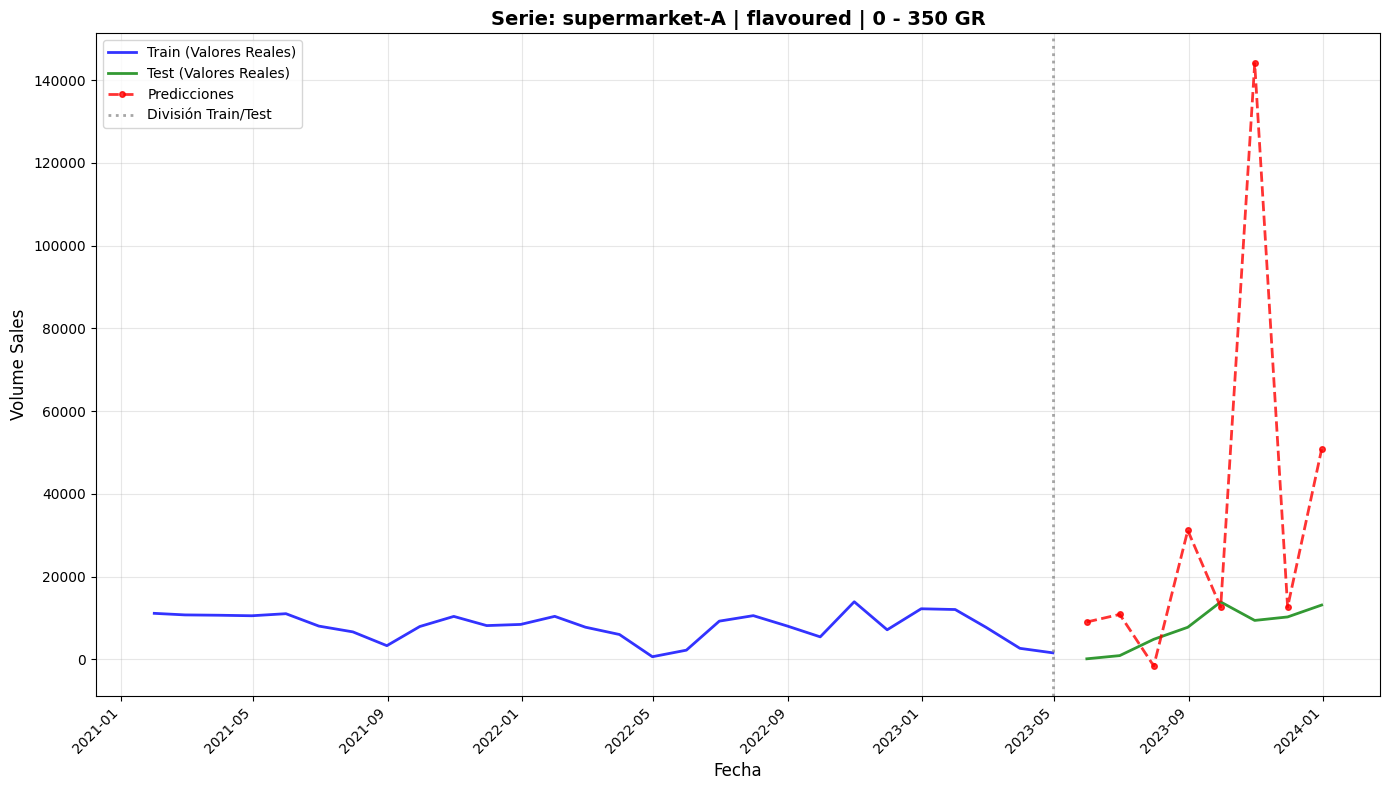


🎯 Serie seleccionada: Índice 1
   - supermarket-A | light | 351 - 500 GR


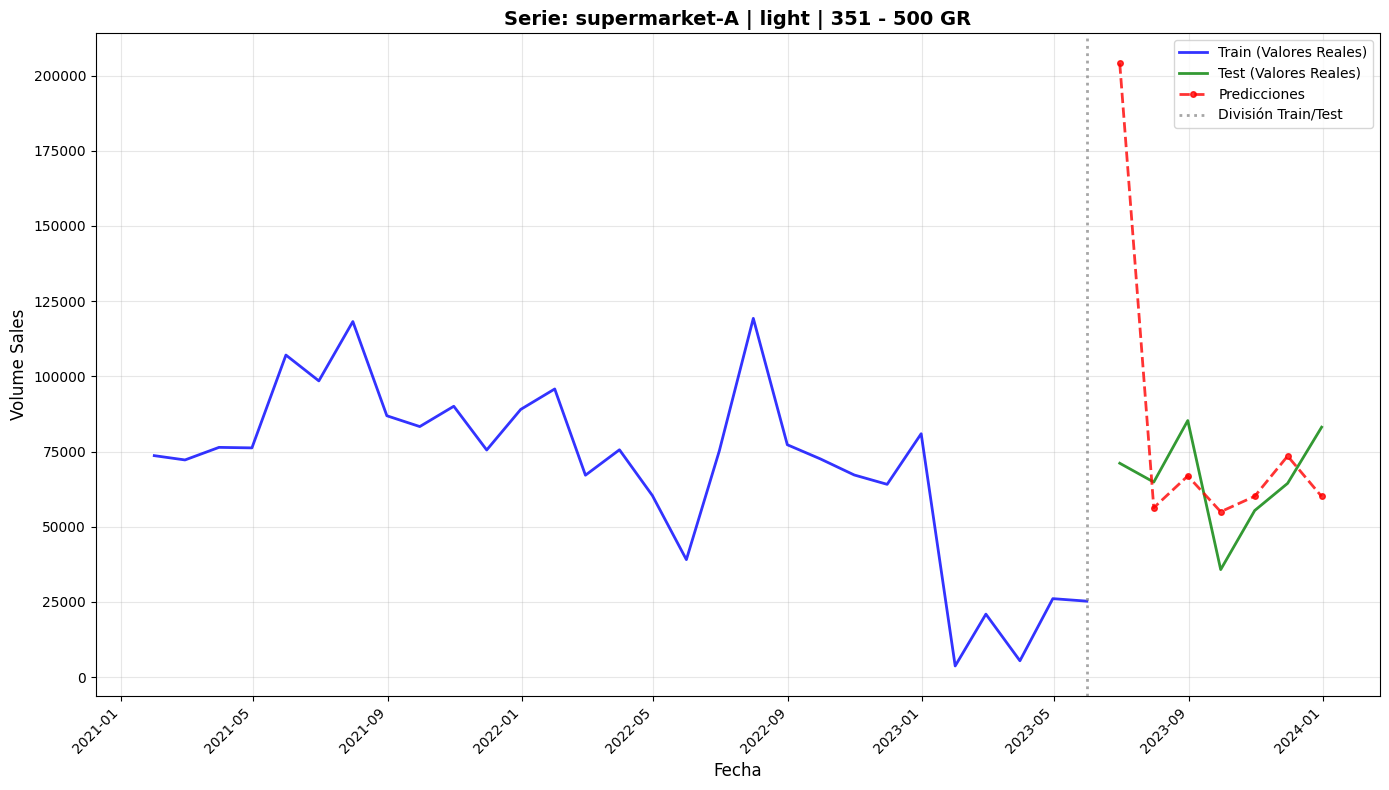


🎯 Serie seleccionada: Índice 2
   - supermarket-A | standard | 351 - 500 GR


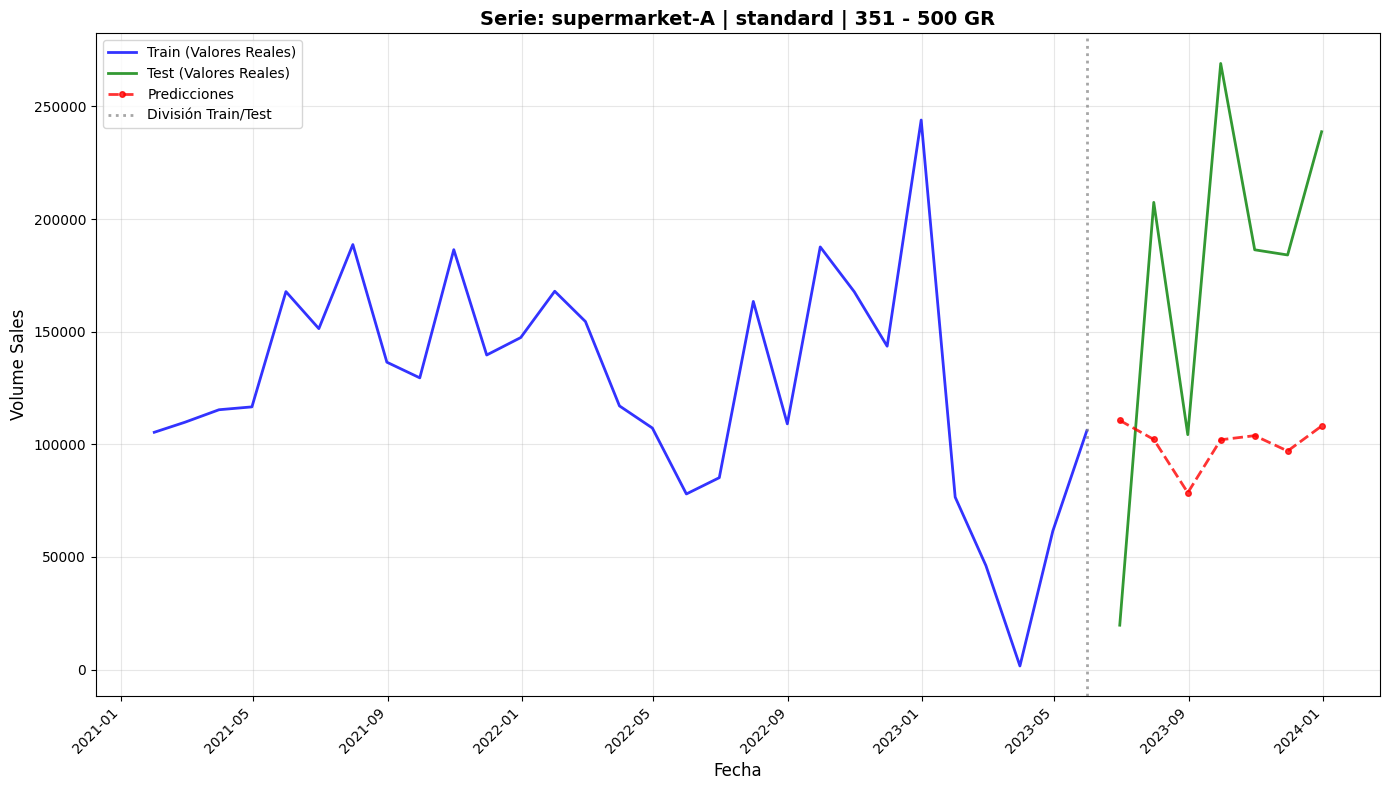


🎯 Serie seleccionada: Índice 3
   - supermarket-A | vegan | 0 - 350 GR


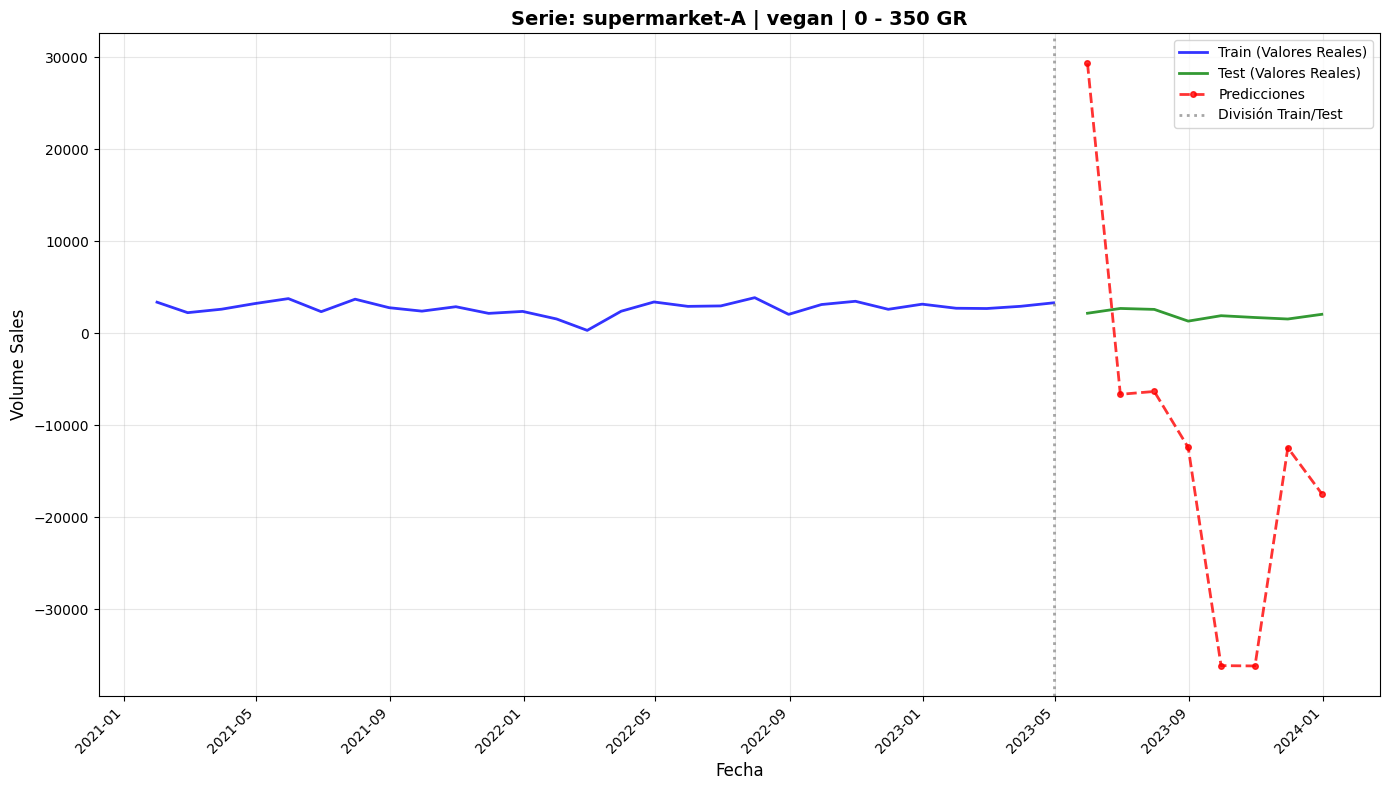


🎯 Serie seleccionada: Índice 4
   - supermarket-B | flavoured | 0 - 350 GR


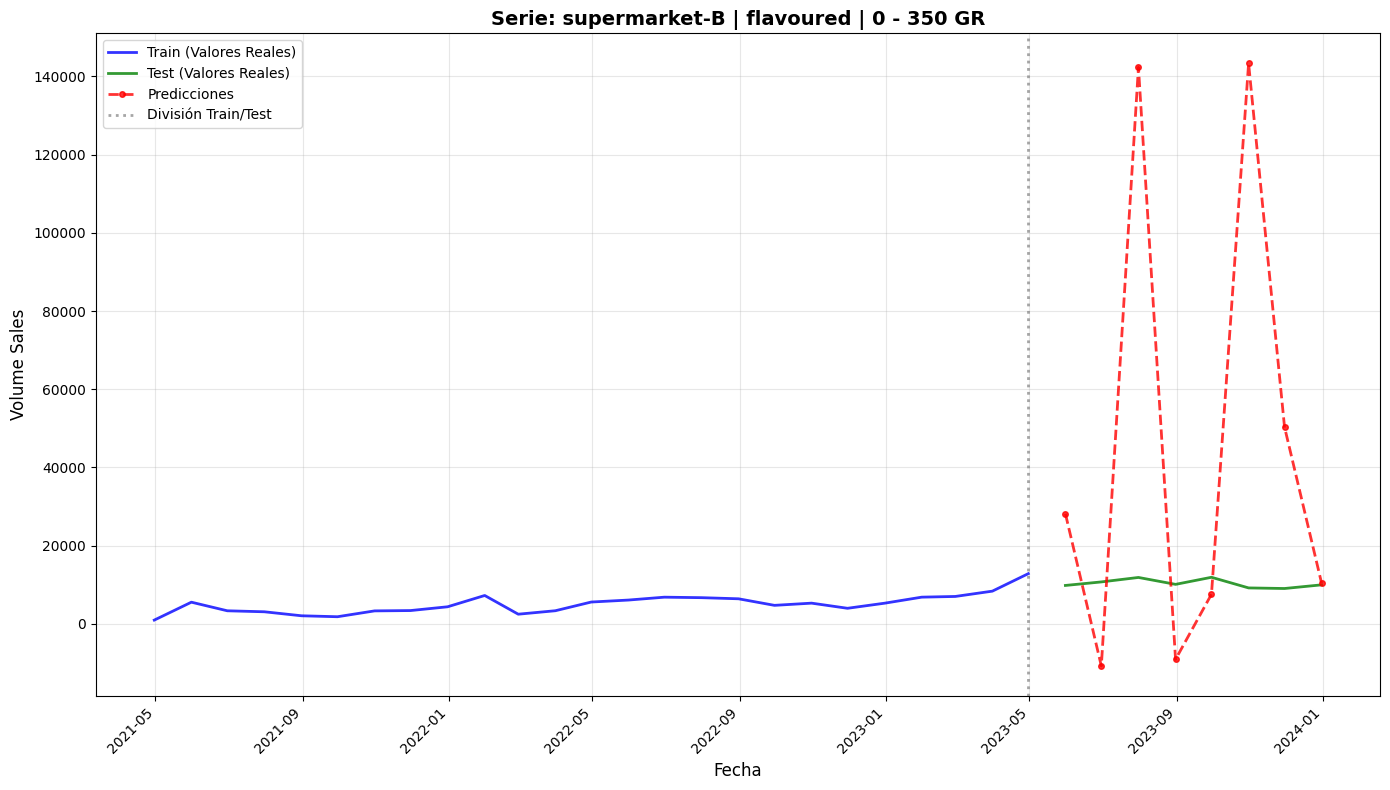


🎯 Serie seleccionada: Índice 5
   - supermarket-B | light | 351 - 500 GR


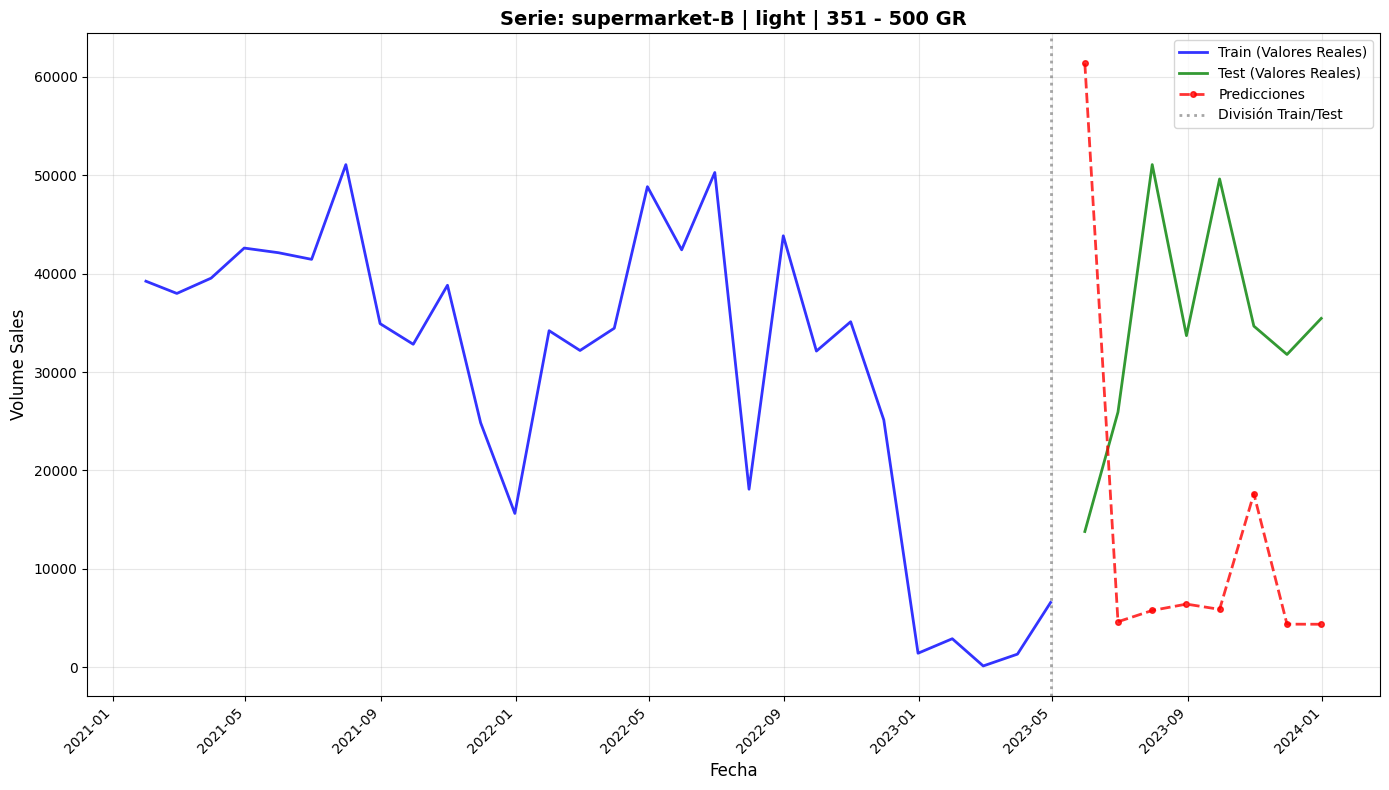


🎯 Serie seleccionada: Índice 6
   - supermarket-B | light | 701 - 1000 GR


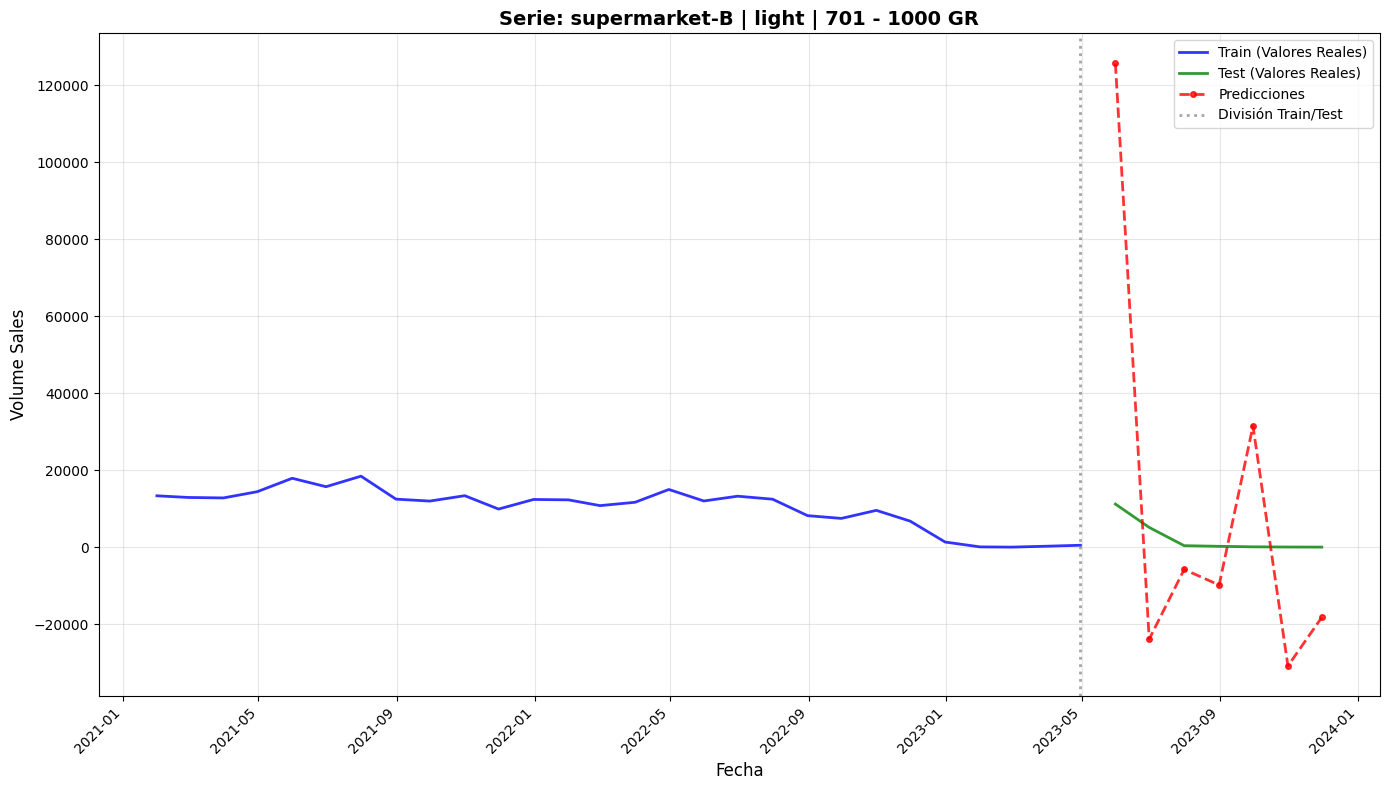


🎯 Serie seleccionada: Índice 7
   - supermarket-B | standard | 0 - 350 GR


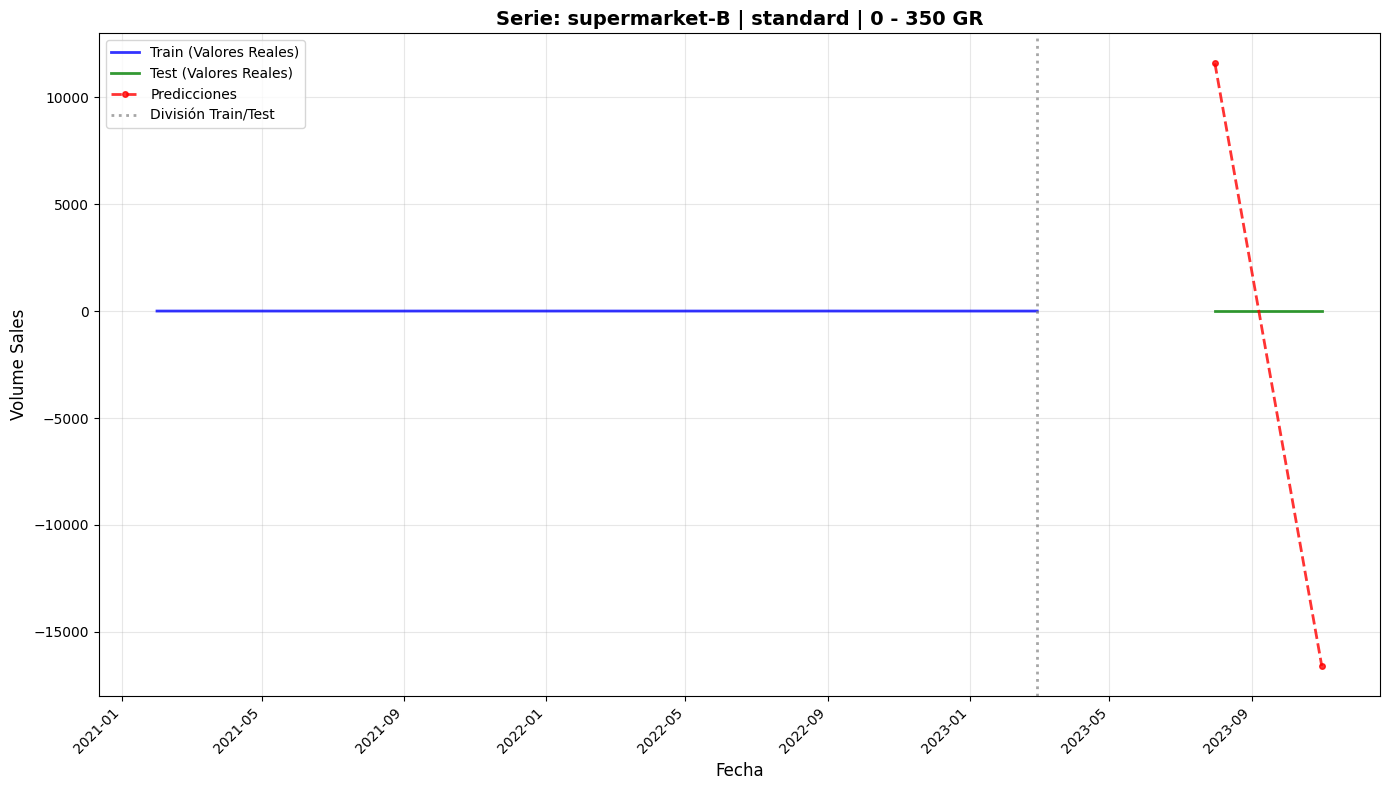


🎯 Serie seleccionada: Índice 8
   - supermarket-B | standard | 351 - 500 GR


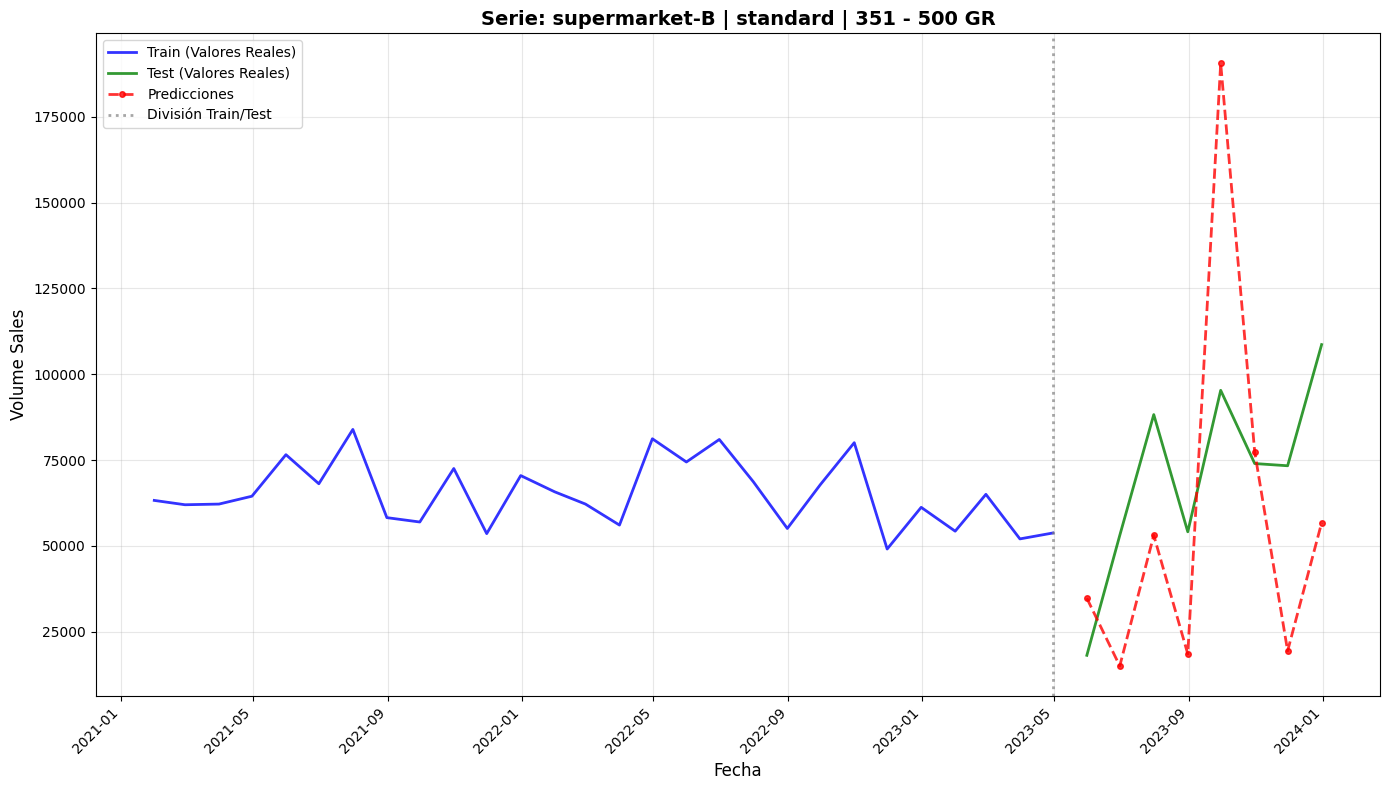


🎯 Serie seleccionada: Índice 9
   - supermarket-B | standard | 701 - 1000 GR


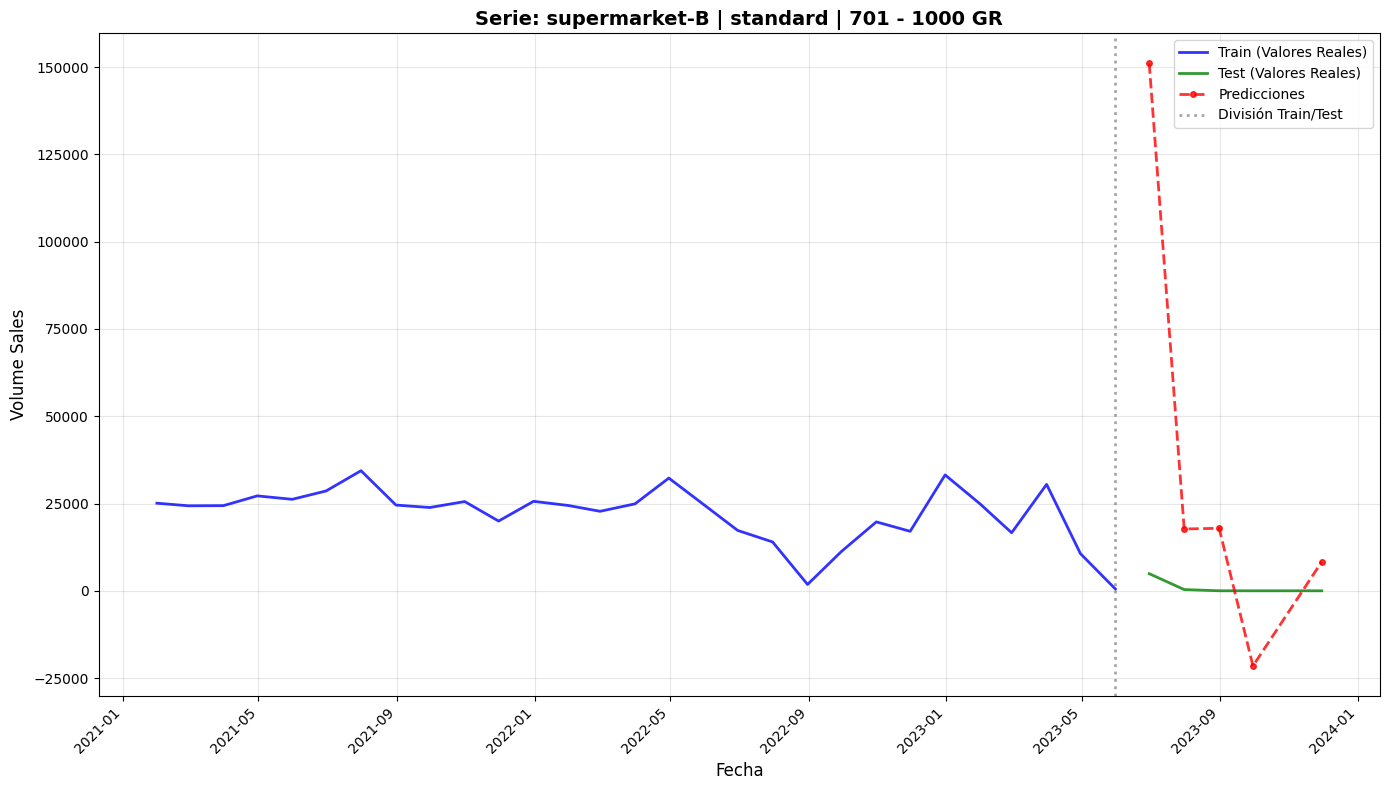


🎯 Serie seleccionada: Índice 10
   - supermarket-B | vegan | 0 - 350 GR


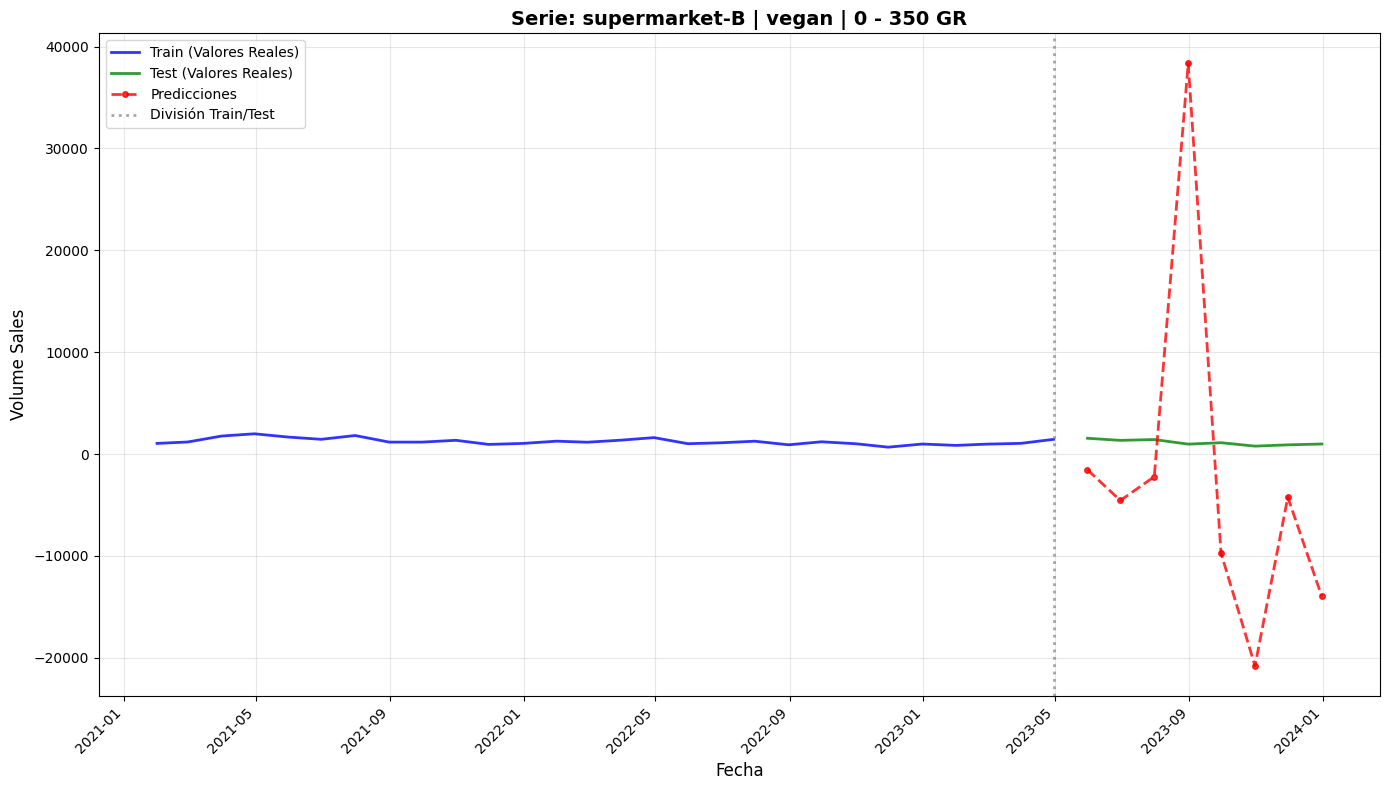


🎯 Serie seleccionada: Índice 11
   - supermarket-C | flavoured | 0 - 350 GR


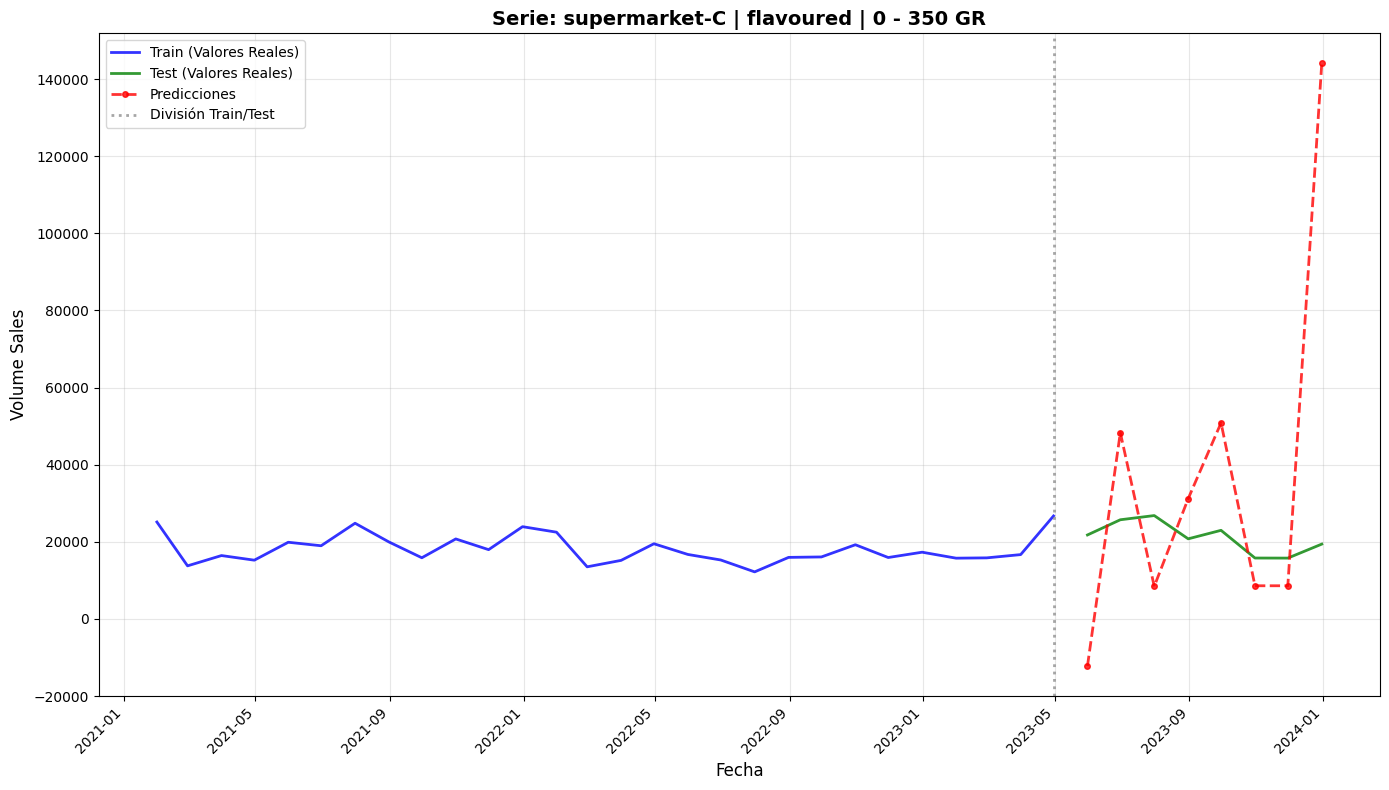


🎯 Serie seleccionada: Índice 12
   - supermarket-C | light | 0 - 350 GR


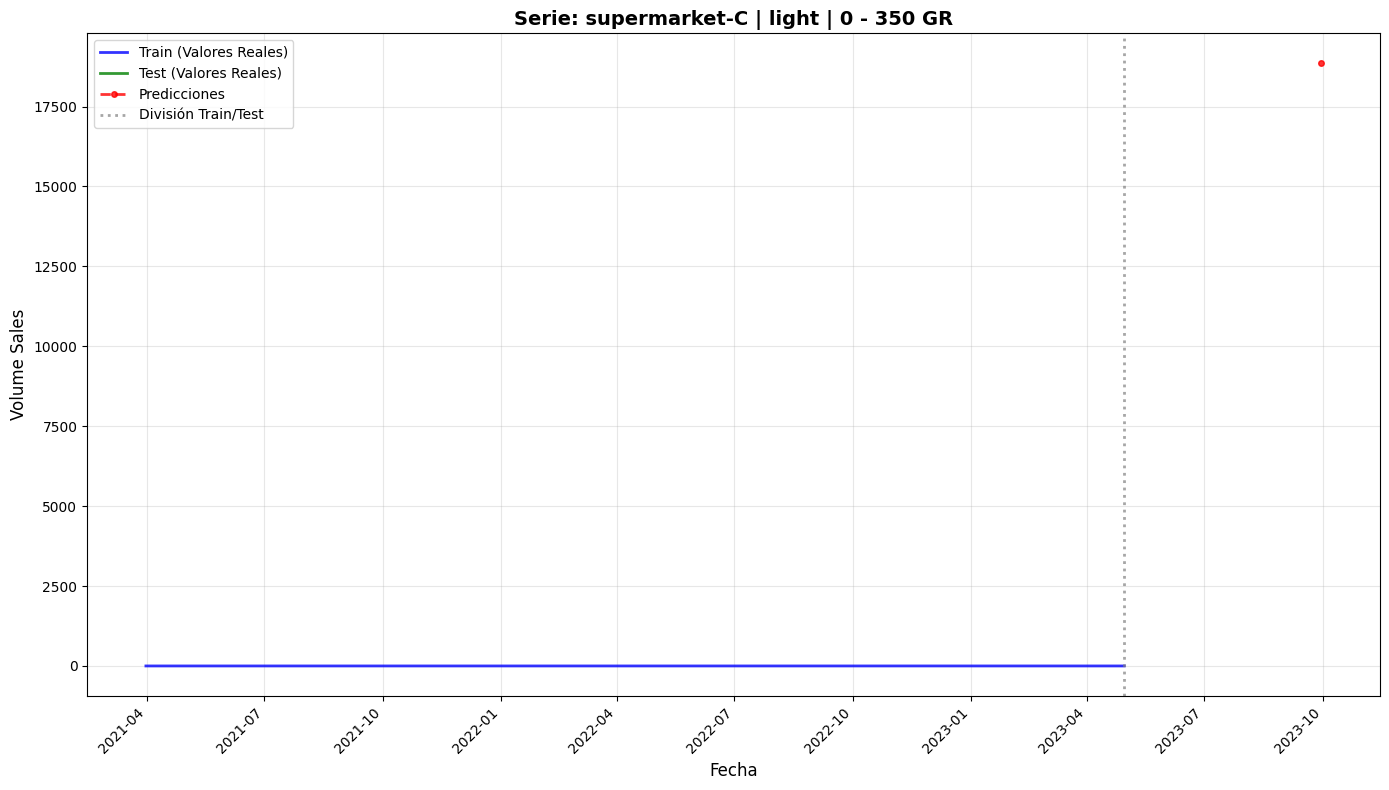


🎯 Serie seleccionada: Índice 13
   - supermarket-C | light | 351 - 500 GR


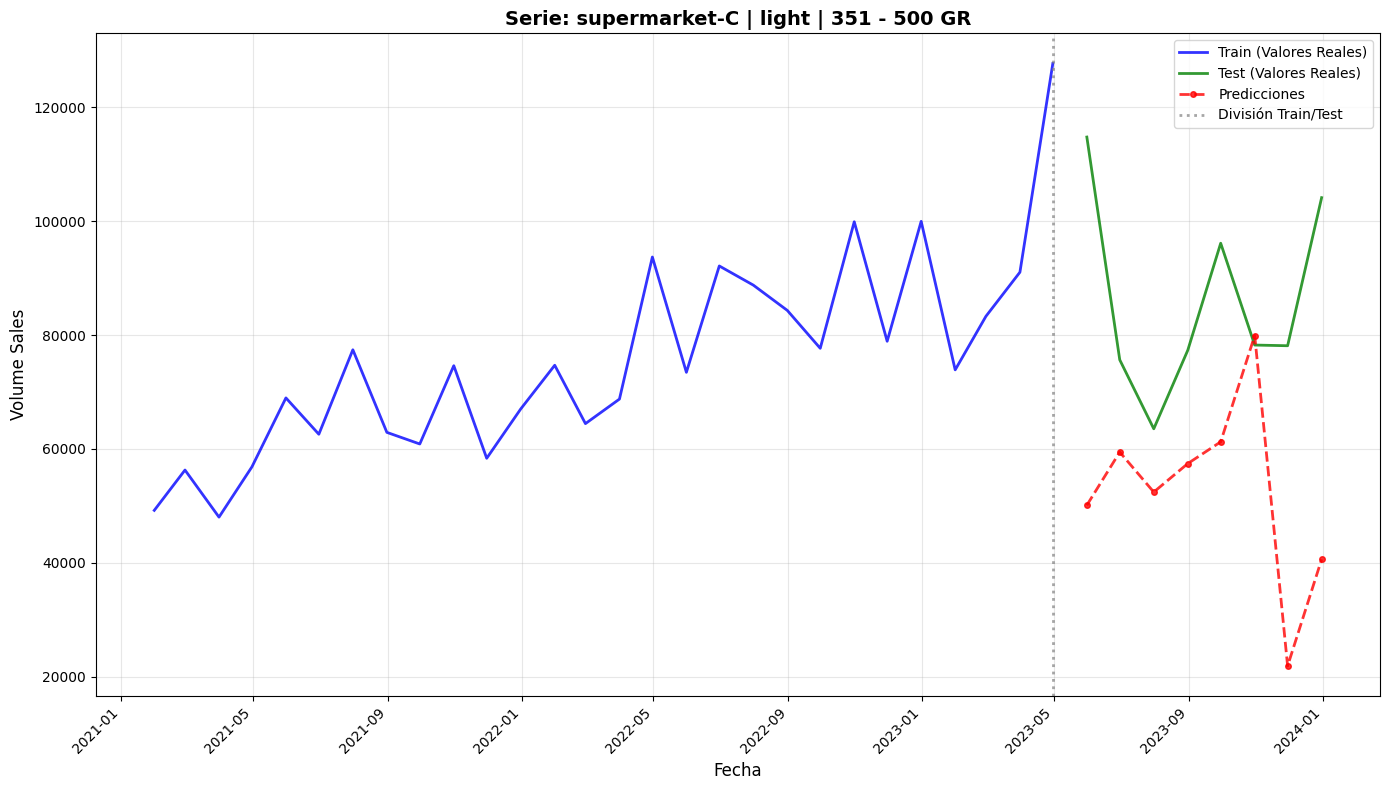


🎯 Serie seleccionada: Índice 14
   - supermarket-C | light | 701 - 1000 GR


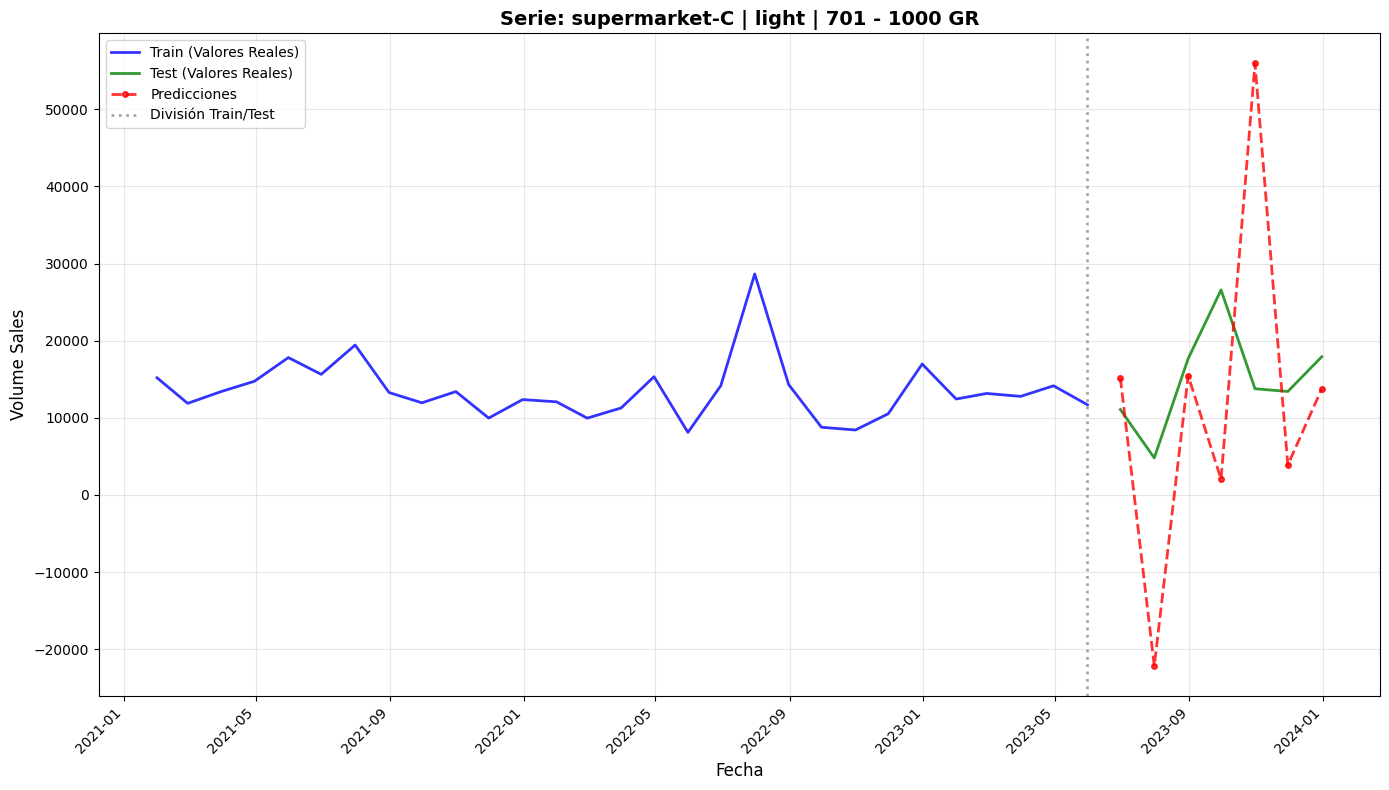


🎯 Serie seleccionada: Índice 15
   - supermarket-C | standard | 0 - 350 GR


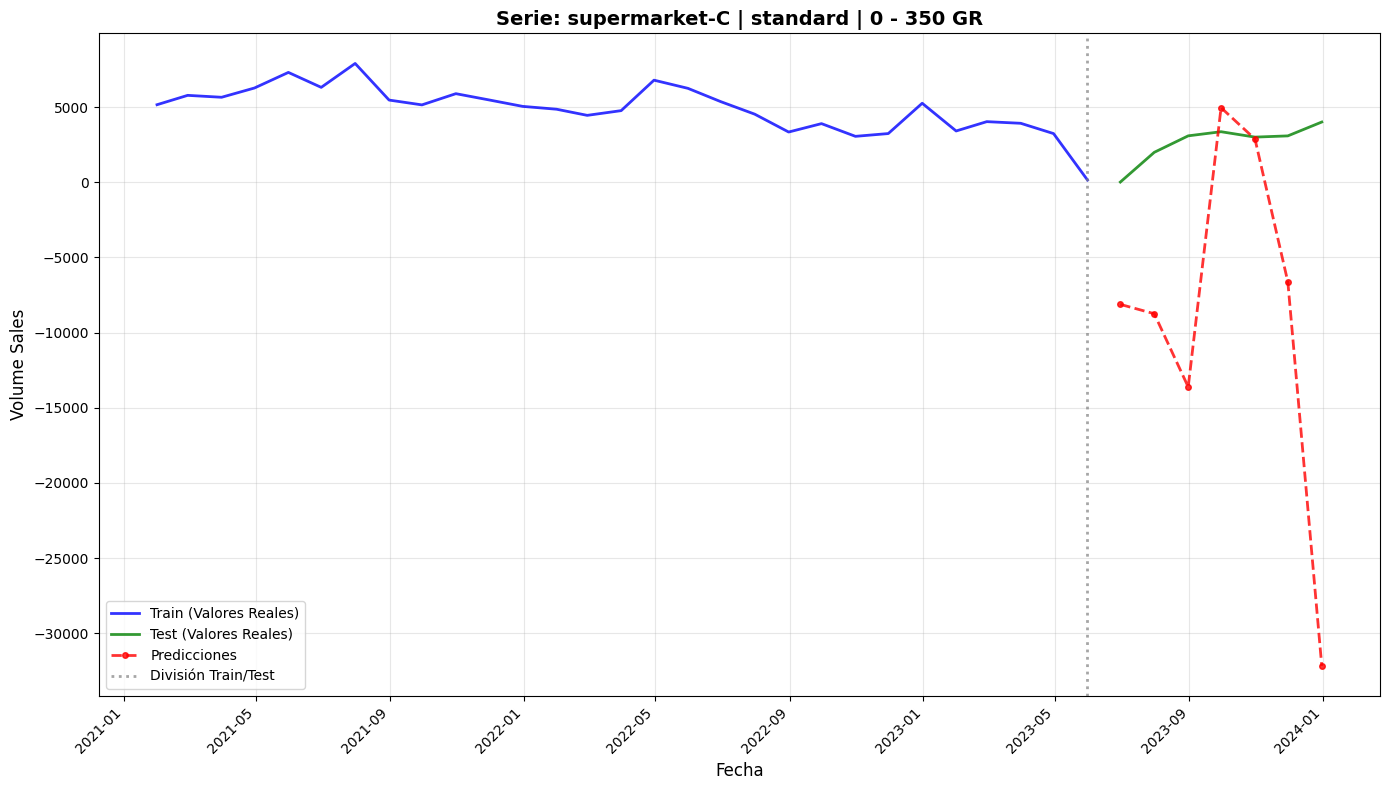


🎯 Serie seleccionada: Índice 16
   - supermarket-C | standard | 351 - 500 GR


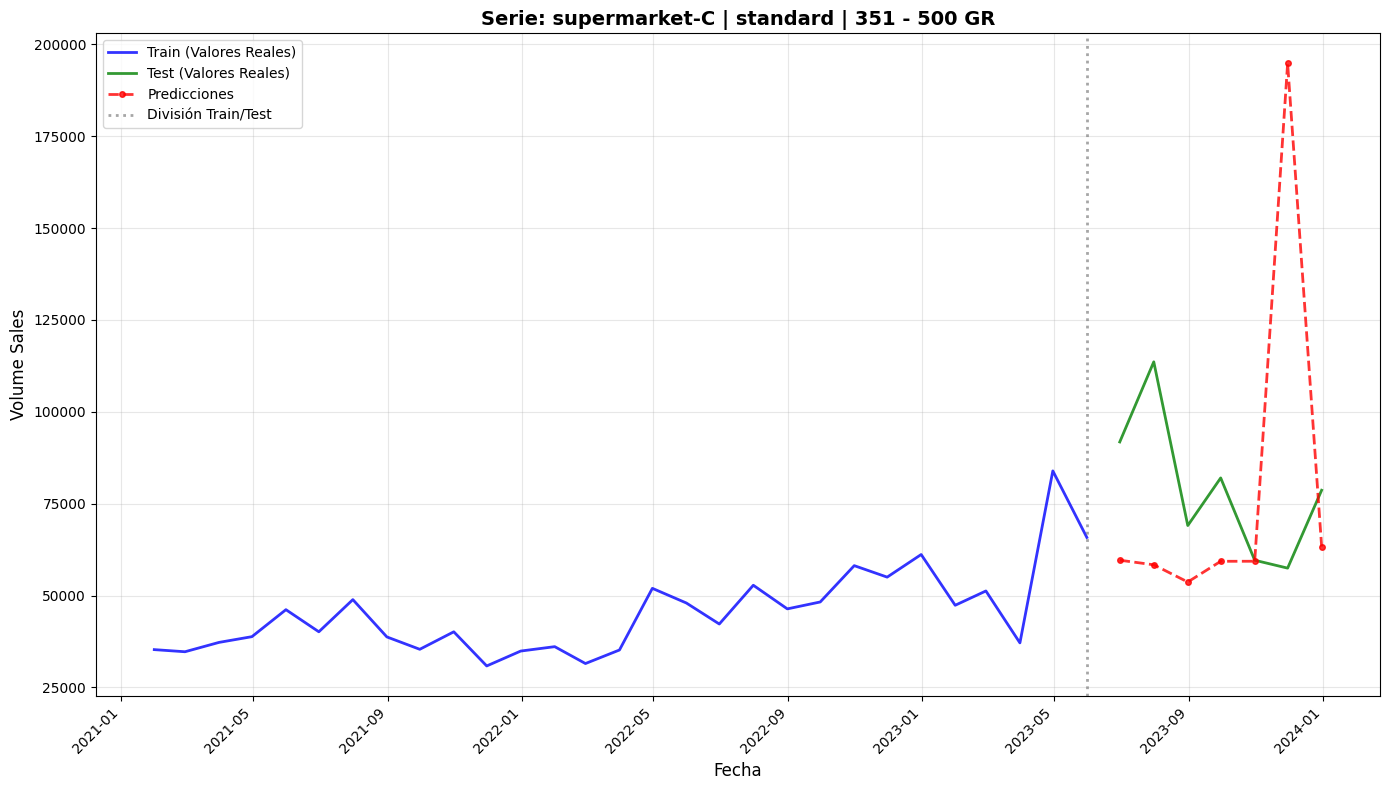


🎯 Serie seleccionada: Índice 17
   - supermarket-C | standard | 701 - 1000 GR


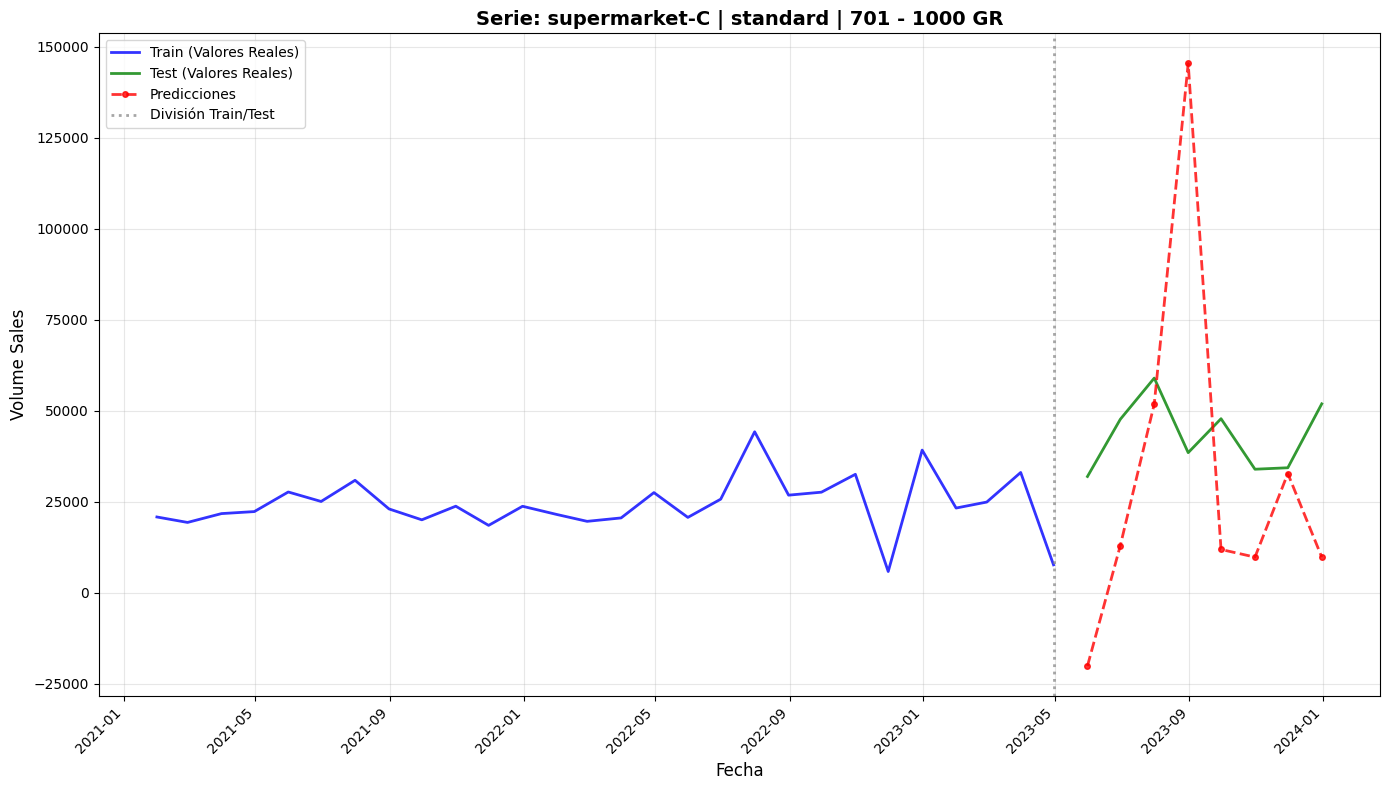


🎯 Serie seleccionada: Índice 18
   - supermarket-D | flavoured | 0 - 350 GR


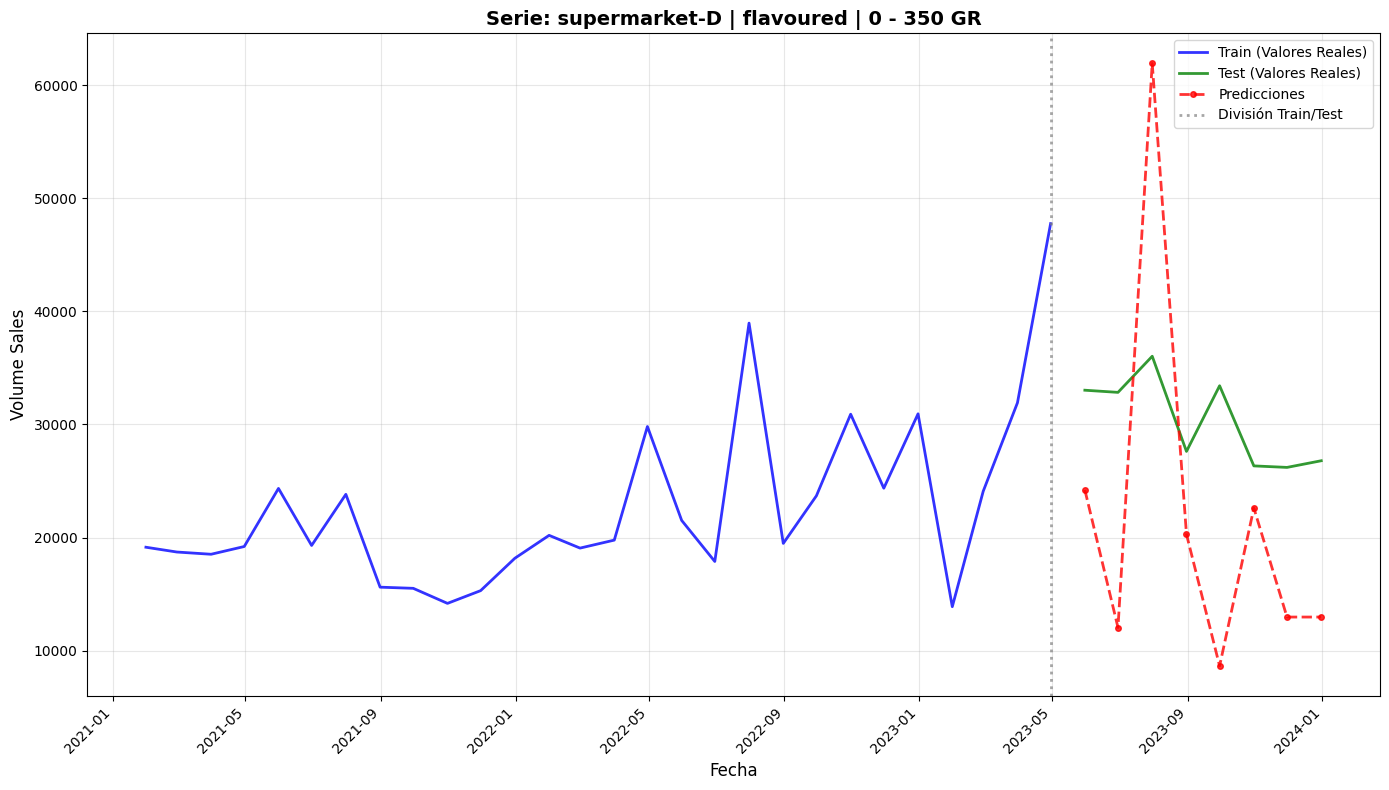


🎯 Serie seleccionada: Índice 19
   - supermarket-D | light | 351 - 500 GR


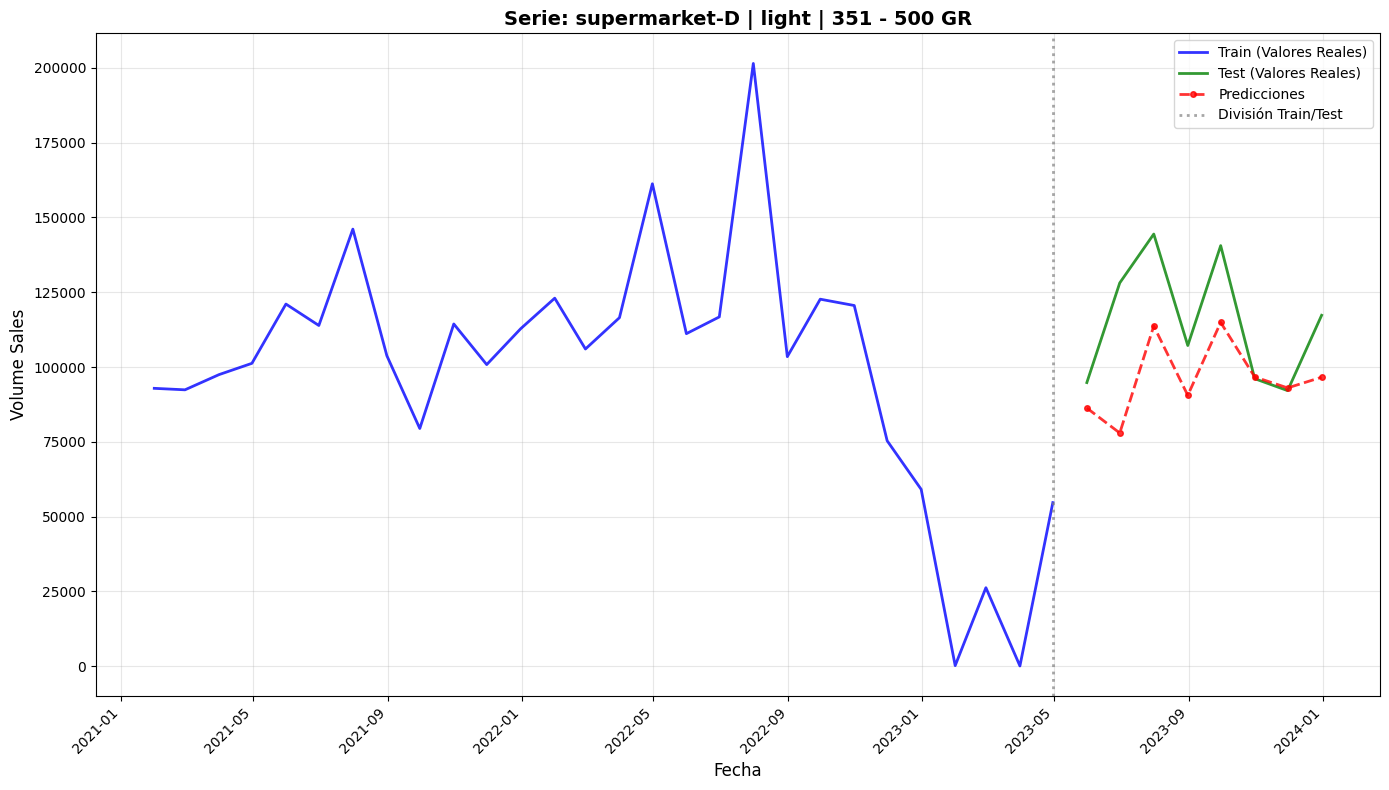


🎯 Serie seleccionada: Índice 20
   - supermarket-D | standard | 351 - 500 GR


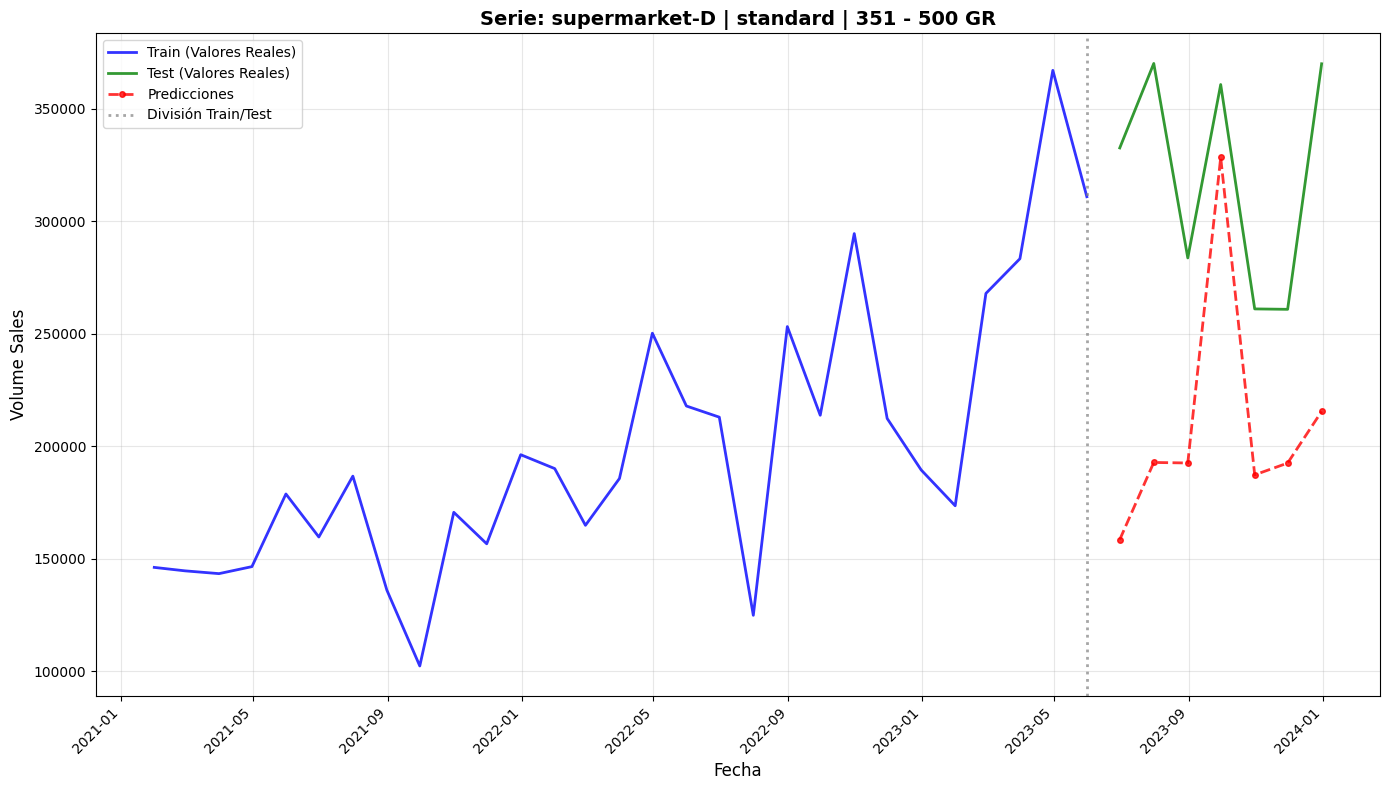


🎯 Serie seleccionada: Índice 21
   - supermarket-D | vegan | 0 - 350 GR


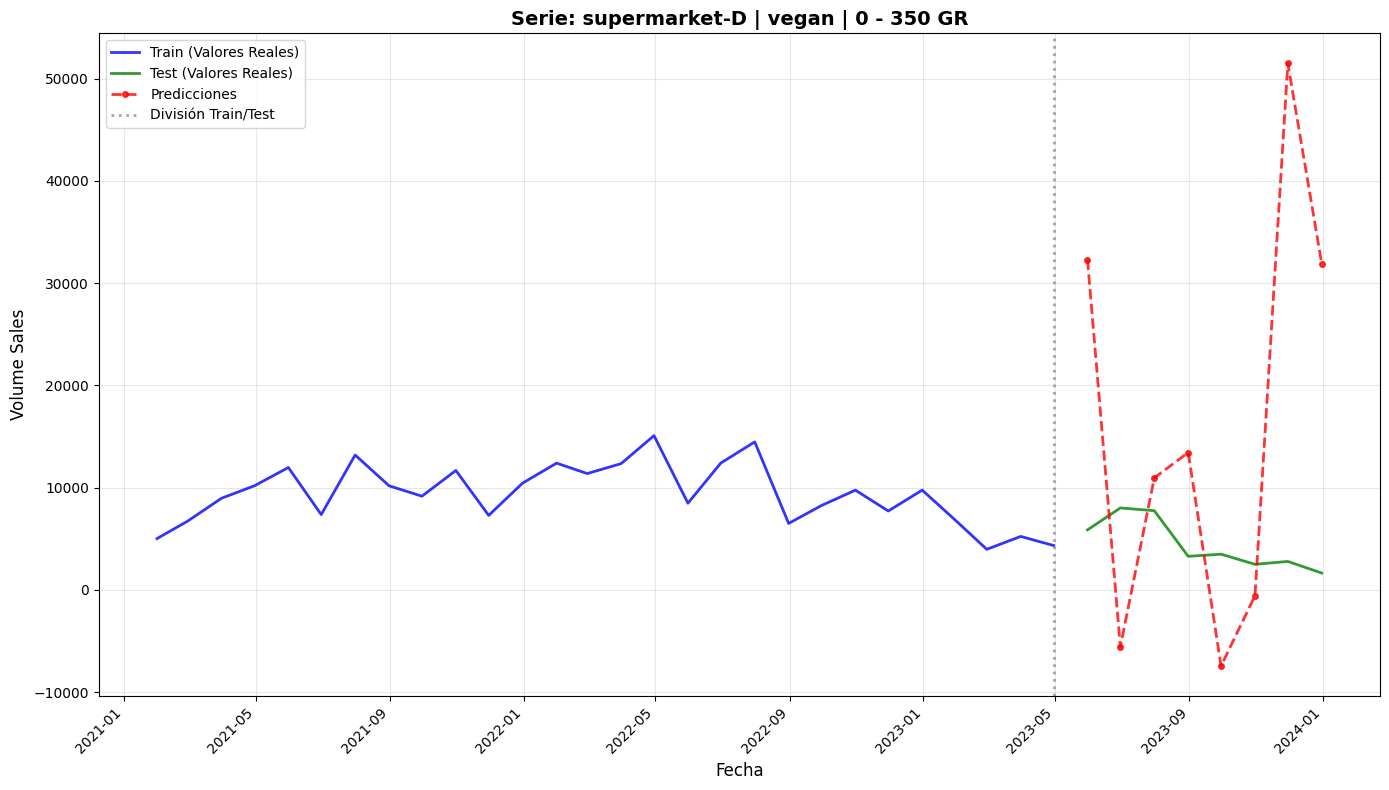

In [ ]:
import matplotlib.pyplot as plt

combinations = data[['supermarket', 'variant', 'pack.size']].drop_duplicates().sort_values(['supermarket', 'variant', 'pack.size'])

available_series = []

for idx, row in combinations.iterrows():
    train_filter = (
        (train_data['supermarket'] == row['supermarket']) &
        (train_data['variant'] == row['variant']) &
        (train_data['pack.size'] == row['pack.size'])
    )
    test_filter = (
        (test_data['supermarket'] == row['supermarket']) &
        (test_data['variant'] == row['variant']) &
        (test_data['pack.size'] == row['pack.size'])
    )
    
    train_count = train_filter.sum()
    test_count = test_filter.sum()
    
    if train_count > 0 and test_count > 0:
        available_series.append({
            'supermarket': row['supermarket'],
            'variant': row['variant'],
            'pack.size': row['pack.size'],
            'train_count': train_count,
            'test_count': test_count
        })

# selected_series = available_series[6] if available_series else None
#######################
# Mostrar todas las series disponibles
print(f"\n✅ Series disponibles en AMBOS (train y test): {len(available_series)}")
for i, series in enumerate(available_series):
    print(f"   {i}. {series['supermarket']} | {series['variant']} | {series['pack.size']} "
          f"(Train: {series['train_count']}, Test: {series['test_count']})")

# Seleccionar serie (cambia el índice según lo que quieras ver)
for i in range(len(available_series)):
    selected_index = i # Índices válidos: 0 a {len(available_series)-1}
    selected_series = available_series[selected_index] if available_series else None

    if selected_series:
        print(f"\n🎯 Serie seleccionada: Índice {selected_index}")
        print(f"   - {selected_series['supermarket']} | {selected_series['variant']} | {selected_series['pack.size']}")
    #######################


    if selected_series is not None:
        # Verificar que existe la tabla con predicciones
        if 'predictions_with_context' not in locals():
            print("❌ Error: La tabla 'predictions_with_context' no existe.")
            print("   Por favor, ejecuta primero la celda donde se crean las predicciones.")
        else:
            # Crear el filtro para la serie seleccionada
            series_filter = (
                (predictions_with_context['supermarket'] == selected_series['supermarket']) &
                (predictions_with_context['variant'] == selected_series['variant']) &
                (predictions_with_context['pack.size'] == selected_series['pack.size'])
            )
            
            # Filtrar train_data por la serie seleccionada
            train_filter = (
                (train_data['supermarket'] == selected_series['supermarket']) &
                (train_data['variant'] == selected_series['variant']) &
                (train_data['pack.size'] == selected_series['pack.size'])
            )
            train_filtered = train_data[train_filter].copy()
            
            # Filtrar la tabla completa (test_data + predicciones) con el mismo filtro
            # Esto filtra automáticamente tanto test_data como predicciones porque están en la misma tabla
            test_and_predictions_filtered = predictions_with_context[series_filter].copy()
            
            # Ordenar por fecha si existe la columna date
            if 'date' in train_filtered.columns:
                train_filtered = train_filtered.sort_values('date').reset_index(drop=True)
            if 'date' in test_and_predictions_filtered.columns:
                test_and_predictions_filtered = test_and_predictions_filtered.sort_values('date').reset_index(drop=True)
            
            # Extraer valores para el gráfico desde las tablas filtradas
            train_volume = train_filtered['volume.sales'].values
            test_volume = test_and_predictions_filtered['volume.sales'].values
            predictions_filtered = test_and_predictions_filtered['prediction'].values
            
            # Extraer fechas
            if 'date' in train_filtered.columns:
                train_dates = train_filtered['date'].values
            else:
                train_dates = train_filtered.index
            
            if 'date' in test_and_predictions_filtered.columns:
                test_dates = test_and_predictions_filtered['date'].values
                prediction_dates = test_and_predictions_filtered['date'].values
            else:
                test_dates = test_and_predictions_filtered.index
                prediction_dates = test_and_predictions_filtered.index
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        if 'date' in train_filtered.columns:
            train_x = train_dates
        else:
            train_x = range(len(train_volume))
        
        if 'date' in test_and_predictions_filtered.columns:
            test_x = test_dates
            prediction_x = prediction_dates
        else:
            test_x = range(len(train_volume), len(train_volume) + len(test_volume))
            prediction_x = range(len(train_volume), len(train_volume) + len(predictions_filtered))
        
        ax.plot(train_x, train_volume, 
                label='Train (Valores Reales)', 
                color='blue', 
                linewidth=2,
                alpha=0.8)
        
        ax.plot(test_x, test_volume, 
                label='Test (Valores Reales)', 
                color='green', 
                linewidth=2,
                alpha=0.8)
        
        ax.plot(prediction_x, predictions_filtered, 
                label='Predicciones', 
                color='red', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                marker='o',
                markersize=4)
        
        if len(train_volume) > 0:
            if 'date' in train_filtered.columns:
                cutoff_date = train_dates[-1] if hasattr(train_dates, '__getitem__') else train_x[-1]
                ax.axvline(x=cutoff_date if hasattr(cutoff_date, '__str__') else train_x[-1], 
                        color='gray', 
                        linestyle=':', 
                        linewidth=2,
                        label='División Train/Test',
                        alpha=0.7)
            else:
                ax.axvline(x=len(train_volume)-0.5, 
                        color='gray', 
                        linestyle=':', 
                        linewidth=2,
                        label='División Train/Test',
                        alpha=0.7)
        
        title = f"Serie: {selected_series['supermarket']} | {selected_series['variant']} | {selected_series['pack.size']}"
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha' if 'date' in train_filtered.columns else 'Período', fontsize=12)
        ax.set_ylabel('Volume Sales', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        if 'date' in train_filtered.columns:
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
